In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
import cv2
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
path2train="training_set/training_set/"
dir = ''
train_imgsList = sorted(glob.glob(dir+'training_set/training_set/*HC.png'))
train_anntList = sorted(glob.glob(dir+'training_set/training_set/*_Annotation.png'))
test_imgsList = sorted(glob.glob(dir+'test_set/test_set/*HC.png'))
test_anntList =sorted(glob.glob(dir+'test_set/test_set/*HC_Annotation.png'))

print("number of images:", len(train_imgsList))
print("number of annotations:", len(train_anntList))

number of images: 999
number of annotations: 999


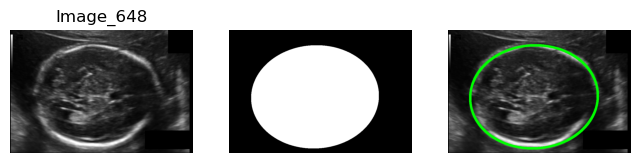

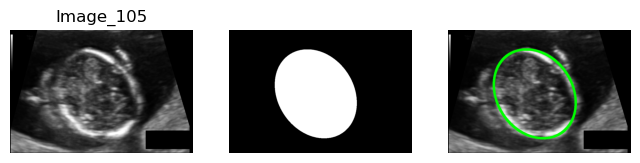

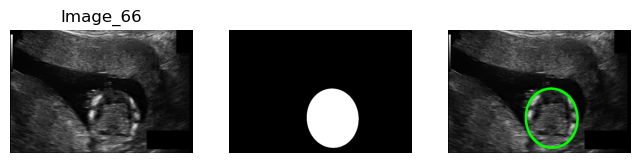

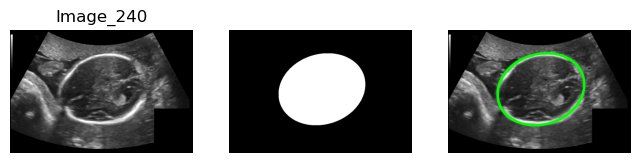

In [3]:
random_numbers = np.random.randint(0,1000,4)
for random_number in random_numbers:
    img = Image.open(train_imgsList[random_number])
    annt_edges = Image.open(train_anntList[random_number])
    mask = ndi.binary_fill_holes(annt_edges)
    plt.figure(figsize=[8,14])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Image_{}".format(random_number))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    contours, hierarchy = cv2.findContours(np.array(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = img.copy()
    image=np.array(image,np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(image, contours, -1, (0,255,0), 10)
    plt.imshow(image)
    plt.axis("off")

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision
from torchvision.transforms.functional import to_tensor,to_pil_image

In [5]:
class fetal_dataset(Dataset):
    def __init__(self, path2data, ds = "train",train_size = 799):
        self.path2imgs = sorted(glob.glob(path2data+'*HC.png'))
        self.path2annts= sorted(glob.glob(path2data+'*_Annotation.png'))
    def __len__(self):
        return len(self.path2imgs)
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)
        image= np.array(image)
        mask=mask.astype("uint8")
        image= to_tensor(image)
        mask=255*to_tensor(mask)
        image = torchvision.transforms.functional.resize(image, (128,192), interpolation=2)
        mask = torchvision.transforms.functional.resize(mask, (128,192), interpolation=2)
        return image, mask

In [6]:
path2train="training_set/training_set/"
fetal_ds=fetal_dataset(path2train,ds="train")
print(len(fetal_ds))

999


In [7]:
img,mask=fetal_ds[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


# Q1.

In [8]:
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import Subset
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=range(len(fetal_ds))
for train_index, val_index in sss.split(indices):
    train_ds=Subset(fetal_ds,train_index)
    print("Size of train data = ",len(train_ds))
    val_ds=Subset(fetal_ds,val_index)
    print("Size of Validation data = ", len(val_ds))

Size of train data =  799
Size of Validation data =  200


In [9]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)

# Q2.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_outputs=params["num_outputs"]
        self.conv1 = nn.Conv2d(C_in, init_f,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f,kernel_size=3,padding=1)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear', align_corners=True)
        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f,kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f,kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f,kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f,kernel_size=3,padding=1)
        self.conv_out = nn.Conv2d(init_f, num_outputs,kernel_size=3,padding=1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv5(x))
        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))
        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))
        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))
        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))
        x = self.conv_out(x)
        return x
params_model={
 "input_shape": (1,128,192),
 "initial_filters": 16,
 "num_outputs": 1,
 }
model = SegNet(params_model)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else
'cpu')
model=model.to(device)

In [13]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [14]:
from torchsummary import summary
summary(model, input_size=(1, 128, 192), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

In [15]:
def dice_loss(pred, target, smooth = 1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    #print("inter",intersection)
    #print("union",union)
    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice
    return loss.sum(), dice.sum()
import torch.nn.functional as F
def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,reduction='sum')
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    return loss
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    return metric
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    pred = torch.sigmoid(output)
    _, metric_b=dice_loss(pred, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)


In [16]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float32).to(device)
        yb=yb.type(torch.float32).to(device)
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

In [17]:
import copy
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss,train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss,val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        print("train loss: %.6f, dice: %.2f"%(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f"%(val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history
import os
path2models= "./models/"
if not os.path.exists(path2models):
    os.mkdir(path2models)
params_train={
 "num_epochs": 20,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": path2models+"weights.pt",
}
model,loss_hist,metric_hist=train_val(model,params_train)


Epoch 0/19, current lr=0.0003
Copied best model weights!
train loss: 9025.791117, dice: 58.51
val loss: 6404.705376, dice: 70.17
----------
Epoch 1/19, current lr=0.0003
Copied best model weights!
train loss: 5629.797243, dice: 73.58
val loss: 4366.273478, dice: 77.01
----------
Epoch 2/19, current lr=0.0003
Copied best model weights!
train loss: 3716.626857, dice: 81.52
val loss: 3235.315288, dice: 82.77
----------
Epoch 3/19, current lr=0.0003
Copied best model weights!
train loss: 2476.386658, dice: 87.17
val loss: 2491.278100, dice: 87.91
----------
Epoch 4/19, current lr=0.0003
Copied best model weights!
train loss: 1916.196501, dice: 90.21
val loss: 2137.823724, dice: 90.50
----------
Epoch 5/19, current lr=0.0003
Copied best model weights!
train loss: 1599.910441, dice: 91.81
val loss: 2024.553925, dice: 91.47
----------
Epoch 6/19, current lr=0.0003
Copied best model weights!
train loss: 1445.680856, dice: 92.58
val loss: 1875.806129, dice: 92.46
----------
Epoch 7/19, current 

# Q4.

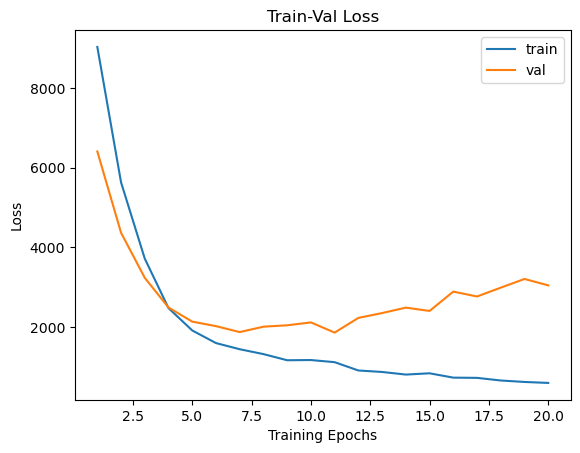

In [18]:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [19]:
for i in range(len(metric_hist["train"])):
    metric_hist["train"][i] = metric_hist["train"][i].to("cpu").detach().numpy()
    metric_hist["val"][i] = metric_hist["val"][i].to("cpu").detach().numpy()

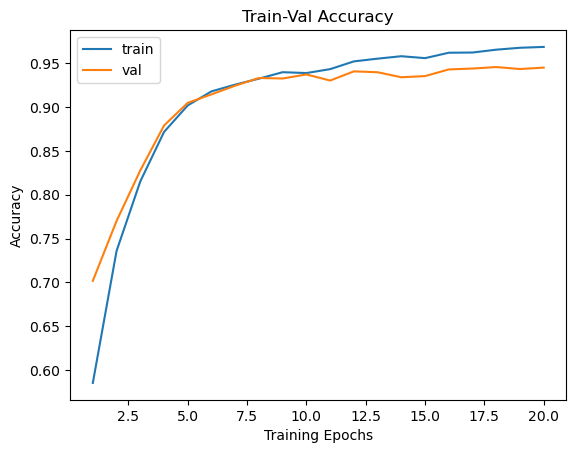

In [20]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


# Q5.

In [21]:
path2weights="./models/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [22]:
img = Image.open(test_imgsList[10])
img=img.resize((128,192))
img_t=to_tensor(img).unsqueeze(0).to(device)
pred=model(img_t)
pred=torch.sigmoid(pred)[0]
mask_pred= (pred[0]>=0.5)

(-0.5, 127.5, 191.5, -0.5)

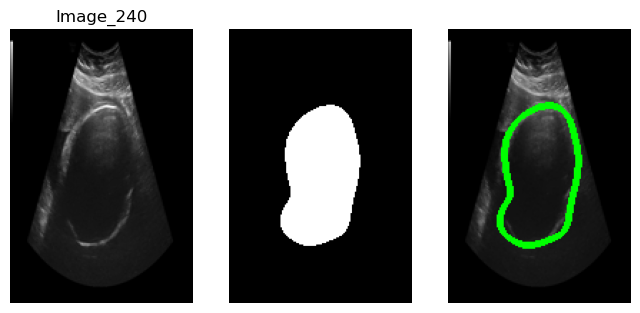

In [23]:
plt.figure(figsize=[8,14])
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Image_{}".format(random_number))
plt.axis("off")
plt.subplot(1, 3, 2)
mask = mask_pred.to("cpu").detach().numpy()
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
contours, hierarchy = cv2.findContours(np.array(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image = img.copy()
image=np.array(image,np.uint8)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(image, contours, -1, (0,255,0), 3)
plt.imshow(image)
plt.axis("off")

In [24]:
'''np.random.seed(100)
random_numbers = np.random.randint(0,100,4)
for random_number in random_numbers:
    img_1 = Image.open(test_imgsList[random_number])
    img=img_1.resize((128,192))
    img_t=to_tensor(img).unsqueeze(0).to(device)
    pred=model(img_t)
    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5)
    #annt_edges = Image.open(train_anntList[random_number])
    #mask = ndi.binary_fill_holes(annt_edges)
    mask=np.array(mask_pred.to("cpu").detach().numpy().copy(),np.float)
    plt.figure(figsize=[8,14])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Image_{}".format(random_number))
    plt.axis("off")
    plt.subplot(1, 3, 2)
    #mask.resize((np.array(img_1).shape[0],np.array(img_1).shape[1])))
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    contours, hierarchy = cv2.findContours(np.array(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = img.copy()
    image=np.array(image,np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(image, contours, -1, (0,255,0), 2)
    plt.imshow(image)
    plt.axis("off")'''

'np.random.seed(100)\nrandom_numbers = np.random.randint(0,100,4)\nfor random_number in random_numbers:\n    img_1 = Image.open(test_imgsList[random_number])\n    img=img_1.resize((128,192))\n    img_t=to_tensor(img).unsqueeze(0).to(device)\n    pred=model(img_t)\n    pred=torch.sigmoid(pred)[0]\n    mask_pred= (pred[0]>=0.5)\n    #annt_edges = Image.open(train_anntList[random_number])\n    #mask = ndi.binary_fill_holes(annt_edges)\n    mask=np.array(mask_pred.to("cpu").detach().numpy().copy(),np.float)\n    plt.figure(figsize=[8,14])\n    plt.subplot(1, 3, 1)\n    plt.imshow(img, cmap="gray")\n    plt.title("Image_{}".format(random_number))\n    plt.axis("off")\n    plt.subplot(1, 3, 2)\n    #mask.resize((np.array(img_1).shape[0],np.array(img_1).shape[1])))\n    plt.imshow(mask, cmap="gray")\n    plt.axis("off")\n    plt.subplot(1, 3, 3)\n    contours, hierarchy = cv2.findContours(np.array(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)\n    image = img.copy()\n    image=np.ar

# UNet Model

In [25]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

'''def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape'''

    
params_model={
 "input_shape": (1,128,192),
 "initial_filters": 16,
 "num_outputs": 1,
 }
model = UNET(in_channels=1,out_channels=1).to(device)

In [26]:
def dice_loss(pred, target, smooth = 1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    #print("inter",intersection)
    #print("union",union)
    dice= 2.0 * (intersection + smooth) / (union+ smooth)
    loss = 1.0 - dice
    return loss.sum(), dice.sum()
import torch.nn.functional as F
def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,reduction='sum')
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    loss = bce + dlv
    return loss
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    return metric
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    pred = torch.sigmoid(output)
    _, metric_b=dice_loss(pred, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)


In [27]:
import copy
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss,train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss,val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        print("train loss: %.6f, dice: %.2f"%(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f"%(val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history
import os
path2models= "./models_unet/"
if not os.path.exists(path2models):
    os.mkdir(path2models)
params_train={
 "num_epochs": 10,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": path2models+"weights.pt",
}
model,loss_hist,metric_hist=train_val(model,params_train)


Epoch 0/9, current lr=0.0003
Copied best model weights!
train loss: 4018.459958, dice: 80.84
val loss: 3051.543594, dice: 85.73
----------
Epoch 1/9, current lr=0.0003
Copied best model weights!
train loss: 1878.951343, dice: 90.81
val loss: 2968.133883, dice: 86.13
----------
Epoch 2/9, current lr=0.0003
Copied best model weights!
train loss: 1744.495844, dice: 91.87
val loss: 2421.042452, dice: 86.68
----------
Epoch 3/9, current lr=0.0003
train loss: 1253.439298, dice: 94.18
val loss: 3643.282518, dice: 88.07
----------
Epoch 4/9, current lr=0.0003
train loss: 1152.755745, dice: 94.73
val loss: 2621.862738, dice: 88.49
----------
Epoch 5/9, current lr=0.0003
train loss: 1083.453352, dice: 95.22
val loss: 2585.877200, dice: 90.32
----------
Epoch 6/9, current lr=0.0003
train loss: 1071.024659, dice: 95.30
val loss: 2488.460648, dice: 92.02
----------
Epoch 7/9, current lr=0.0003
Copied best model weights!
train loss: 1204.426762, dice: 94.68
val loss: 1982.112265, dice: 91.49
-------

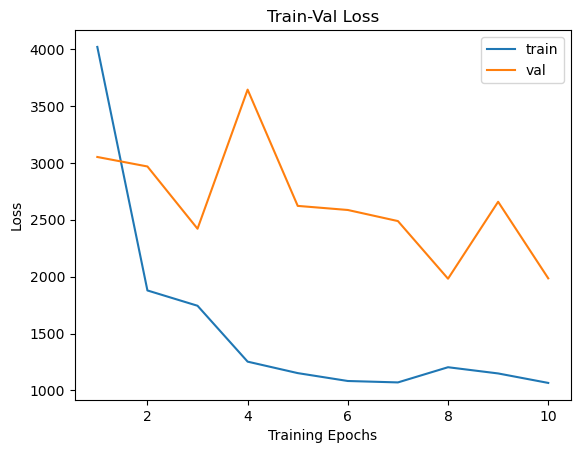

In [28]:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [29]:
for i in range(len(metric_hist["train"])):
    metric_hist["train"][i] = metric_hist["train"][i].to("cpu").detach().numpy()
    metric_hist["val"][i] = metric_hist["val"][i].to("cpu").detach().numpy()

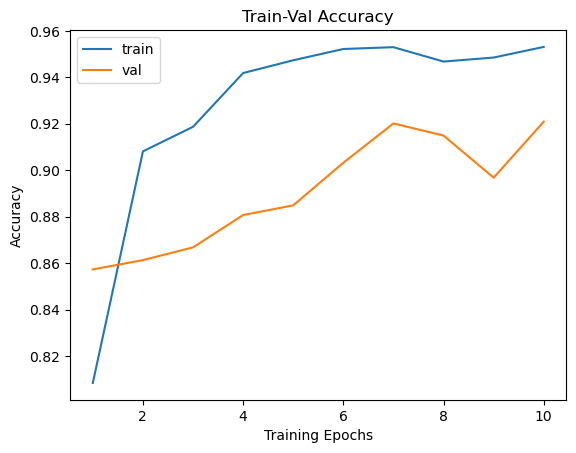

In [30]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [31]:
path2weights="./models_unet/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [52]:
img = Image.open(test_imgsList[10])
img=img.resize((128,192))
img_t=to_tensor(img).unsqueeze(0).to(device)
pred=model(img_t)
pred=torch.sigmoid(pred)[0]
mask_pred= (pred[0]>=0.5)

(-0.5, 127.5, 191.5, -0.5)

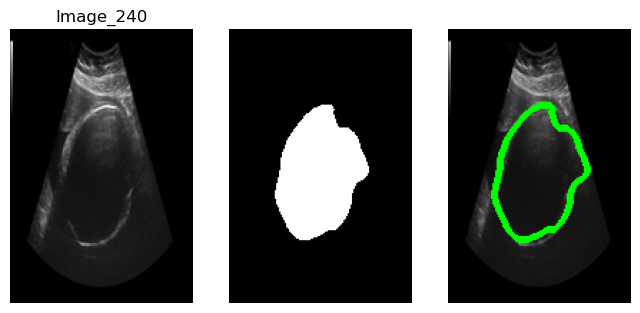

In [53]:
plt.figure(figsize=[8,14])
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Image_{}".format(random_number))
plt.axis("off")
plt.subplot(1, 3, 2)
mask = mask_pred.to("cpu").detach().numpy()
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
contours, hierarchy = cv2.findContours(np.array(mask,np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image = img.copy()
image=np.array(image,np.uint8)
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(image, contours, -1, (0,255,0), 3)
plt.imshow(image)
plt.axis("off")

Usually UNet model performs better because of the skip-connections. Since I used batch size of 1 the dice score values for validation sets are nearly same for both the models.